In [1]:
#Import the required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
!pip install visualkeras

### Dataset Augmentation: Add operating condition history as features

In [4]:
# Takes raw dataset as an input, then performs clustering by operating settings.
# Returns a dataframe with an additional column called operating_condition as output.
def cluster(read_path, sub_dataset):
    print("Clustering for FD{}".format(sub_dataset))
    # Read files:
    train_data = pd.read_csv(read_path+"train_FD"+sub_dataset+".txt", sep = " ", header = None)
    test_data = pd.read_csv(read_path+"test_FD"+sub_dataset+".txt", sep = " ", header = None)

    # Add column names
    trainTestColumns = ['Engine', 'Cycle',
                        'setting1', 'setting2', 'setting3',
                        'Fan Inlet Temperature (◦R)',
                       'LPC Outlet Temperature (◦R)',
                       'HPC Outlet Temperature (◦R)',
                       'LPT Outlet Temperature (◦R)',
                       'Fan Inlet Pressure (psia)',
                       'Bypass-Duct Pressure (psia)',
                       'HPC Outlet Pressure (psia)',
                       'Physical Fan Speed (rpm)',
                       'Physical Core Speed (rpm)',
                       'Engine Pressure Ratio (P50/P2)',
                       'HPC Outlet Static Pressure (psia)',
                       'Ratio of Fuel Flow to Ps30 (pps/psia)',
                       'Corrected Fan Speed (rpm)',
                       'Corrected Core Speed (rpm)', 
                       'Bypass Ratio',
                       'Burner Fuel-Air Ratio',
                       'Bleed Enthalpy',
                       'Required Fan Speed',
                       'Required Fan Conversion Speed',
                       'High-Pressure Turbines Cool Air Flow', 
                       'Low-Pressure Turbines Cool Air Flow',
                       'Sensor 26',
                       'Sensor 27']
    train_data.columns = test_data.columns = trainTestColumns

    # Clustering
    input_kmeans = train_data[["setting1", "setting2", "setting3"]]
    
    estimator=KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=500, tol=0.0001, 
                 verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
    
    estimator.fit(input_kmeans)
    train_data_labels = estimator.labels_
    
    test_data_labels = estimator.predict(test_data[["setting1", "setting2", "setting3"]])

    #Visualizing Clusters
    fig = plt.figure(dpi=100)
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    ax.scatter(test_data['setting1'],test_data['setting2'],test_data['setting3'],
               c=test_data_labels.astype(float),cmap='Greens', edgecolor='k', s=150)
    
    ax.set_xlabel('Operating Setting 1')
    ax.set_ylabel('Operating Setting 2')
    ax.set_zlabel('Operating Setting 3')
    
    ax.set_title('FD'+sub_dataset+' Test Data Operating Modes', fontsize=20)
    ax.dist = 14
    plt.show()
    
    #Adding labels column to the main dataframe
    train_data["operating_condition"] = train_data_labels
    test_data["operating_condition"] = test_data_labels
    
    print("Complete Clustering for FD{} and added a column named operating_condition".format(sub_dataset))

    return train_data, test_data

In [5]:
# Takes dataframe generated by cluster() as input. 
# Calculates history of operating conditions and if save = True generates a new .csv file 
# of the original data plus the six columns indicating operating history.
def oc_history_cols(read_path, sub_dataset, train_data, test_data, save=False):
    
    if "operating_condition" not in train_data.columns or "operating_condition" not in test_data.columns:
        print("Column operating_condition is not found in the data frame")

    else:
        print("Adding History Columns in the Data Frame")
        train_data[["oc_0","oc_1","oc_2","oc_3","oc_4","oc_5"]]= pd.DataFrame([[0,0,0,0,0,0]], index=train_data.index)
        test_data[["oc_0","oc_1","oc_2","oc_3","oc_4","oc_5"]]= pd.DataFrame([[0,0,0,0,0,0]], index=test_data.index)
        
        for file in ["train", "test"]:
            if file == "train":
                groupby_traj = train_data.groupby('Engine', sort=False)
            else:
                groupby_traj = test_data.groupby('Engine', sort=False)
                
            additional_oc=[]
            for Engine, data in groupby_traj:
                data=data.reset_index()
                for i in range(data.shape[0]):
                    check_oc=data.iloc[i]["operating_condition"]
                    if  i != data.shape[0]-1:
                        value = data.iloc[i+1]["oc_"+str(int(check_oc))] + 1
                        for idx in range(i+1, len(data)):
                            data.at[idx, "oc_"+str(int(check_oc))] = value
                        #data.at[i+1:, "oc_"+str(int(check_oc))]=data.iloc[i+1]["oc_"+str(int(check_oc))]+1
                additional_oc.append(data)
            
            oc_cols=pd.concat(additional_oc,  sort=False, ignore_index=False)
            oc_cols=oc_cols.set_index('index', drop=True)
            
            if save:
                print("Saving the {} data with operating condition history columns".format(file))
                oc_cols.to_csv(read_path+file+"_FD"+sub_dataset+"_cluster.csv", index=False)
    return None

In [6]:
read_path = "CMAPSSData/"

In [7]:
# Dataset 001:
train_data, test_data = cluster(read_path, "002")
oc_history_cols(read_path, "002", train_data, test_data, save=True)

Clustering for FD002


<Figure size 640x480 with 0 Axes>

Complete Clustering for FD002 and added a column named operating_condition
Adding History Columns in the Data Frame
Saving the train data with operating condition history columns
Saving the test data with operating condition history columns


In [8]:
# Computes the RUL of engines for the given dataset. 
# Reads true RUL values from the RUl file and calculates RUL using knee_RUL 
# Returns a list of computed RUL values 
def compute_rul(max_life, true_rul_df, data_set, finaltest=False, id='Engine'):
    MAXLIFE = max_life
    rul = []
    true_rul = true_rul_df.iloc[:, 0].tolist()
    #print(true_rul)
    # true_rul.columns = ["RUL"]
    unique_set = pd.unique(data_set['Engine'])
    # print("Length of true_rul['RUL']:", len(true_rul))

    for _id in unique_set :
        #print(_id)
        unique_engine_ID = data_set[data_set['Engine'] == _id]
        cycle_list = unique_engine_ID['Cycle'].tolist()
        
        if finaltest:
            #print("_id - 1:", _id - 1)
            max_cycle = max(cycle_list) + true_rul[_id-1] #_id-1
            #print(max(cycle_list), true_rul[_id-1])
        else:
            max_cycle = max(cycle_list)
        #if max_cycle < MAXLIFE:
        #print('<130 _id {} | max_cycle {}'.format(_id, max_cycle))
        rul.extend(knee_RUL(cycle_list, max_cycle, MAXLIFE))

    data_set["RUL"]=rul
        
    return data_set

In [9]:
# Computes the RUL of engines using a piecewise linear function with zero and unit gradients. 
# Generates a list of RUL values based on the given cycle and life thresholds. 
def knee_RUL(cycle_list, max_cycle, MAXLIFE):
    '''
    Piecewise linear function with zero gradient and unit gradient
            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_RUL = []
    if max_cycle >= MAXLIFE:
        knee_point = max_cycle - MAXLIFE
        
        for i in range(0, len(cycle_list)):
            if i < knee_point:
                knee_RUL.append(MAXLIFE)
            else:
                #print(knee_point)
                #print(knee_RUL)
                tmp = knee_RUL[i - 1] - (MAXLIFE / (max_cycle - knee_point))
                knee_RUL.append(tmp)
    else:
        knee_point = MAXLIFE
        print("=========== knee_point < MAXLIFE ===========")
        for i in range(0, len(cycle_list)):
            knee_point -= 1
            knee_RUL.append(knee_point)
            
    return knee_RUL

In [10]:
rul_doc = pd.read_csv('CMAPSSData/RUL_FD002.txt', header=None)
train_data = compute_rul(max_life=125, 
                       true_rul_df=rul_doc,  
                       data_set = train_data,  
                       finaltest=False)
test_data = compute_rul(max_life=125, 
                       true_rul_df=rul_doc,  
                       data_set = test_data,  
                       finaltest=True)

In [11]:
train_data

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,NaN,NaN,5,0,0,0,0,0,0,125.0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,NaN,NaN,2,0,0,0,0,0,0,125.0
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,NaN,NaN,1,0,0,0,0,0,0,125.0
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,NaN,NaN,2,0,0,0,0,0,0,125.0
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,NaN,NaN,1,0,0,0,0,0,0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,2324.92,8852.27,1.07,44.72,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,NaN,NaN,3,0,0,0,0,0,0,4.0
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,2319.17,8915.86,1.26,46.08,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,NaN,NaN,0,0,0,0,0,0,0,3.0
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,1917.37,8114.33,0.94,37.14,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,NaN,NaN,1,0,0,0,0,0,0,2.0
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,1917.36,8112.63,0.94,37.32,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,NaN,NaN,1,0,0,0,0,0,0,1.0


In [12]:
train_data.describe()

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,0.0,0.0,53759.000000,53759.0,53759.0,53759.0,53759.0,53759.0,53759.0,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,11.600746,282.606787,2228.879188,8525.200837,1.094962,42.985172,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423,NaN,NaN,2.448799,0.0,0.0,0.0,0.0,0.0,0.0,86.913354
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,5.431802,146.005306,145.209816,335.812013,0.127469,3.232372,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615,NaN,NaN,1.626339,0.0,0.0,0.0,0.0,0.0,0.0,41.665602
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,5.710000,136.800000,1914.770000,7985.560000,0.930000,36.230000,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,5.720000,139.935000,2211.880000,8321.660000,1.020000,41.910000,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,51.000000
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,9.030000,194.660000,2223.070000,8361.200000,1.020000,42.390000,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200,NaN,NaN,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,103.000000
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,15.490000,394.080000,2323.960000,8778.030000,1.260000,45.350000,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200,NaN,NaN,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,125.000000
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,21.610000,555.820000,2388.390000,9215.660000,1.300000,48.510000,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100,NaN,NaN,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,125.000000


In [13]:
# Drop empty columns
train_data.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

In [14]:
# Drop empty columns
test_data
#test_data.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,2318.96,8763.80,1.26,45.61,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,NaN,NaN,0,0,0,0,0,0,0,125.0
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,2323.95,8713.21,1.08,44.26,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,NaN,NaN,3,0,0,0,0,0,0,125.0
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,2222.67,8340.20,1.02,41.80,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,NaN,NaN,5,0,0,0,0,0,0,125.0
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,2211.58,8313.85,1.02,42.21,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,NaN,NaN,2,0,0,0,0,0,0,125.0
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,1915.10,7997.13,0.94,36.76,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,NaN,NaN,1,0,0,0,0,0,0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,8.00,194.87,2223.24,8367.35,1.02,41.96,183.05,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065,NaN,NaN,5,0,0,0,0,0,0,55.0
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,5.72,138.34,2212.19,8339.94,1.02,42.00,130.74,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075,NaN,NaN,2,0,0,0,0,0,0,54.0
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,5.72,138.27,2212.29,8341.70,1.02,42.15,130.96,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805,NaN,NaN,2,0,0,0,0,0,0,53.0
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,21.61,553.13,2388.05,9077.35,1.30,47.47,522.25,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589,NaN,NaN,4,0,0,0,0,0,0,52.0


#### Define training and testing sets

In [15]:
X_train=train_data.drop('RUL', axis=1)
y_train=train_data[['RUL']]

In [16]:
X_train

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,5,0,0,0,0,0,0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,2,0,0,0,0,0,0
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,1,0,0,0,0,0,0
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,2,0,0,0,0,0,0
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,2324.92,8852.27,1.07,44.72,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,3,0,0,0,0,0,0
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,2319.17,8915.86,1.26,46.08,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,0,0,0,0,0,0,0
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,1917.37,8114.33,0.94,37.14,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,1,0,0,0,0,0,0
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,1917.36,8112.63,0.94,37.32,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,1,0,0,0,0,0,0


In [17]:
y_train

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
53754,4.0
53755,3.0
53756,2.0
53757,1.0


In [18]:
X_test=test_data.drop('RUL', axis=1)
y_test=test_data[['RUL']]

In [19]:
X_test

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,2318.96,8763.80,1.26,45.61,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,NaN,NaN,0,0,0,0,0,0,0
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,2323.95,8713.21,1.08,44.26,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,NaN,NaN,3,0,0,0,0,0,0
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,2222.67,8340.20,1.02,41.80,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,NaN,NaN,5,0,0,0,0,0,0
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,2211.58,8313.85,1.02,42.21,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,NaN,NaN,2,0,0,0,0,0,0
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,1915.10,7997.13,0.94,36.76,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,NaN,NaN,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,8.00,194.87,2223.24,8367.35,1.02,41.96,183.05,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065,NaN,NaN,5,0,0,0,0,0,0
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,5.72,138.34,2212.19,8339.94,1.02,42.00,130.74,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075,NaN,NaN,2,0,0,0,0,0,0
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,5.72,138.27,2212.29,8341.70,1.02,42.15,130.96,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805,NaN,NaN,2,0,0,0,0,0,0
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,21.61,553.13,2388.05,9077.35,1.30,47.47,522.25,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589,NaN,NaN,4,0,0,0,0,0,0


In [20]:
y_test

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
33986,55.0
33987,54.0
33988,53.0
33989,52.0


In [21]:
X_test.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

In [22]:
print(f'The shape of the training data : {X_train.shape} , {y_train.shape}')
print(f'The shape of the testing data : {X_test.shape} , {y_test.shape}')

The shape of the training data : (53759, 33) , (53759, 1)
The shape of the testing data : (33991, 33) , (33991, 1)


#### Normalize data using Standard Scaler

In [23]:
# Normalization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Results Plotting Function

In [24]:
def actual_vs_predicted(model, y_test, y_pred):
    plt.figure(figsize=(20,11))
    plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
    plt.plot(y_pred,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
    plt.title(f'Actual and Predicted for {model}', fontsize=20)                                        
    plt.ylabel('RUL', fontsize=16)                           
    plt.legend()
    plt.savefig(f'Actual VS Predicted {model}.png')
    plt.show()

#### Industry Scoring Function:
Penalizes late predictions heavier than earlier ones. 

In [25]:
def assym_score(y_true, y_pred):
    # Ensure both y_true and y_pred are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate the difference between the prediction and the actual values
    diff = y_pred - y_true
    n = len(y_true)

    # Create masks for positive and negative differences
    positive_mask = diff > 0
    negative_mask = diff < 0

    # Calculate the loss for positive and negative differences
    positive_loss = np.sum(np.where(negative_mask, np.exp(-(diff) / 10) - 1, 0))
    negative_loss = np.sum(np.where(positive_mask, np.exp((diff) / 13) - 1, 0))

    # Calculate total loss and normalize by the number of samples
    total_loss = positive_loss + negative_loss
    return total_loss / n


## Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

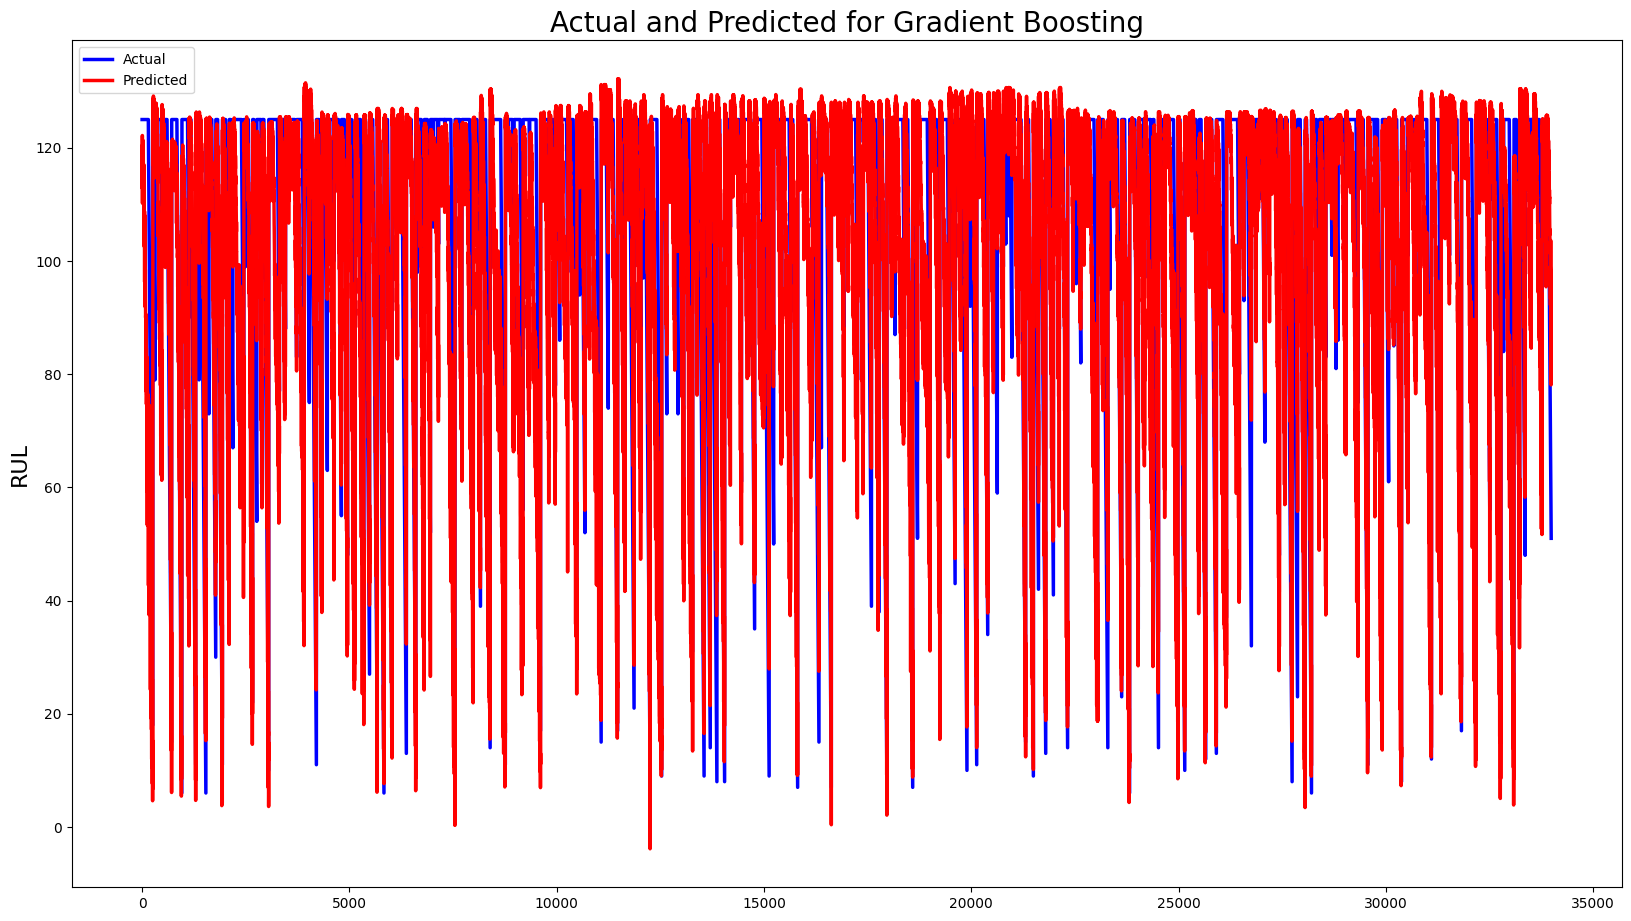

RMSE:  19.42793588889935
Industry score:  32085810.72898726


In [27]:
#Fitting
grad = GradientBoostingRegressor()
grad.fit(X_train,y_train)

#Prediction
y_pred_grad = grad.predict(X_test)

#Evalutation
mse_grad = mean_squared_error(y_test, y_pred_grad)
rmse_grad = mse_grad ** 0.5
assym = assym_score(y_test, y_pred_grad)
acc_grad = round(grad.score(X_train,y_train),2)*100

#Plotting
actual_vs_predicted('Gradient Boosting', y_test, y_pred_grad)

#Results
#Results
print("RMSE: ", rmse_grad)
print("Industry score: ", assym)

### Hyperparameter tuning for Gradient-Boosting Regressor

Parameters to tune:
* learning_rate -> controls the contribution of each tree in the ensemble
* n_estimators -> number of boosting stages to perform
* max_depth -> maximum depth of the individual regression estimators
* min_samples_split -> minimum number of samples required to split an internal node
* min_samples_leaf -> minimum number of samples required to be at a leaf node 
* max_features -> number of features to consider when looking for the best split

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
# Parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [int(x) for x in np.linspace(10,100,10)],
    'max_depth': [int(x) for x in np.linspace(5,30,6)],
    'min_samples_split': [2,5,10,15,100],
    'min_samples_leaf': [1,2,5,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'subsample': [0.6, 0.8, 1.0]
}

In [30]:
# Fitting
hyperparameter_tuned_GB = RandomizedSearchCV(estimator=grad,param_distributions=param_grid)
hyperparameter_tuned_GB.fit(X_train,y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100],
                                        'subsample': [0.6, 0.8, 1.0]})

In [31]:
print('The parameters which are considered to be the best for the model are : ')
hyperparameter_tuned_GB.best_params_

The parameters which are considered to be the best for the model are : 


{'subsample': 0.8,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 15,
 'learning_rate': 0.05}

In [32]:
# Prediction
y_pred_grad_tuned = hyperparameter_tuned_GB.predict(X_test)

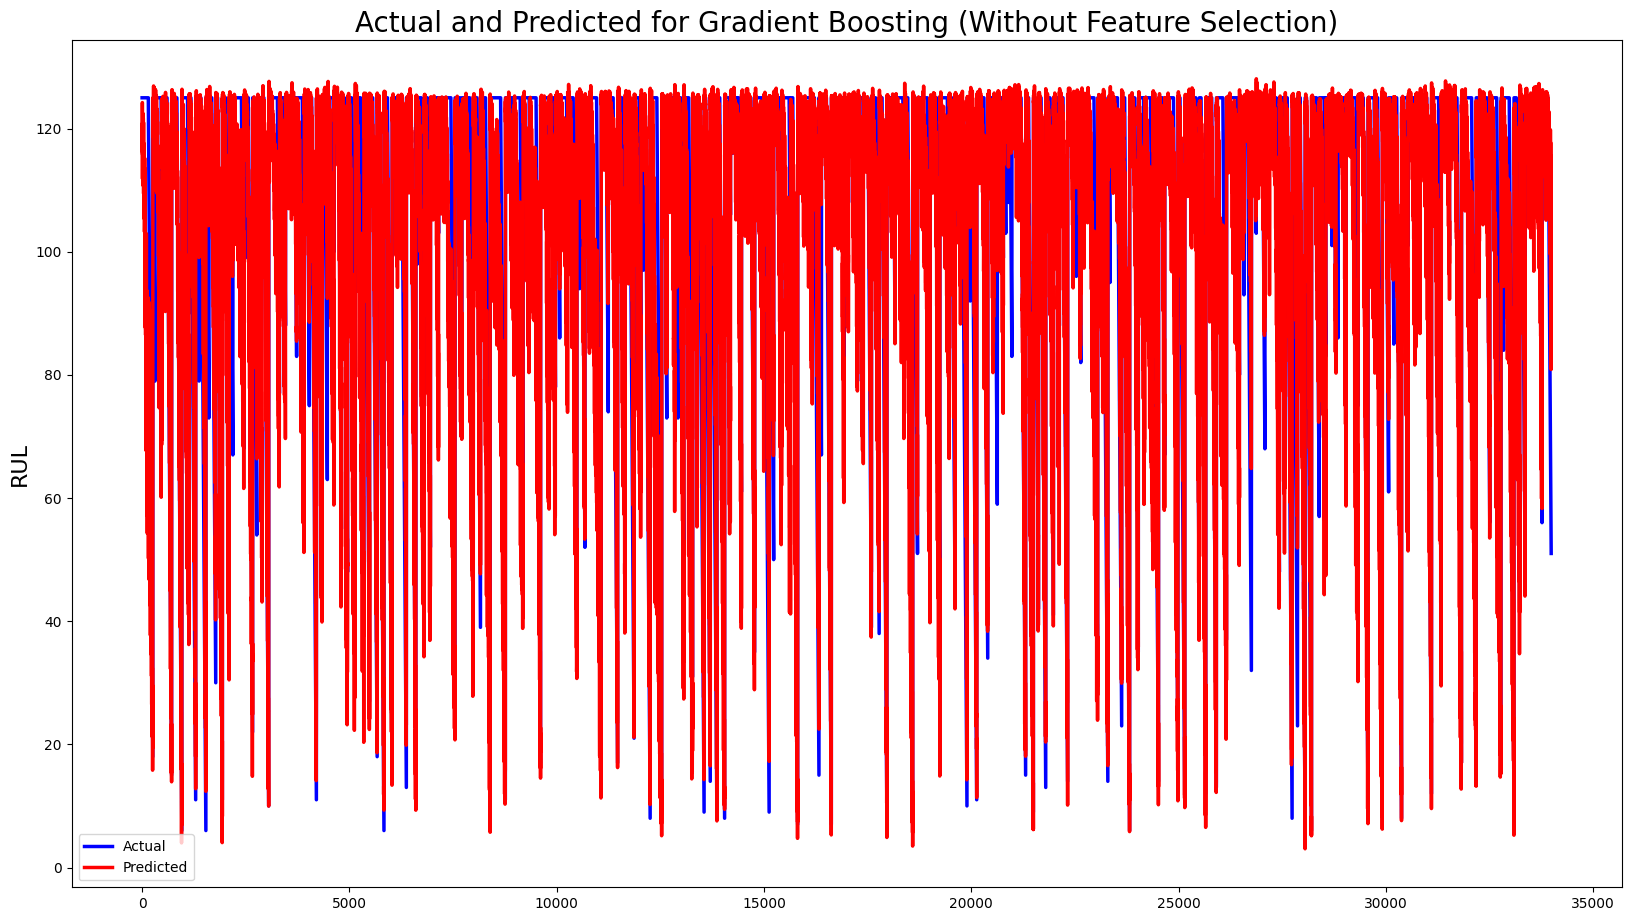

RMSE:  17.042109171845098
Industry score:  34549097.405581355


In [33]:
#Evaluation
mse_grad = mean_squared_error(y_test, y_pred_grad_tuned)
rmse_grad = mse_grad ** 0.5
assym = assym_score(y_test, y_pred_grad_tuned)

#Plotting
actual_vs_predicted('Gradient Boosting (Without Feature Selection)', y_test, y_pred_grad_tuned)

#Results
print("RMSE: ", rmse_grad)
print("Industry score: ", assym)

## Convolutional Neural Network

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

2024-04-17 17:21:18.737376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# model = Sequential()

def create_CNN():
    model = Sequential()
    # Input layer
    model.add(Conv1D(14, 4, activation='sigmoid', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(2, strides=2))
    
    # Hidden layers
    model.add(Conv1D(8, 2, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(8, 12, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(6, 6, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    
    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    
    # Output layer
    model.add(Dense(1))
    return model

model = create_CNN()

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size = 10, epochs = 30)

Epoch 1/30
5376/5376 [==============================] - 4s 618us/step - loss: 7938.2373
Epoch 2/30
5376/5376 [==============================] - 3s 600us/step - loss: 5747.5425
Epoch 3/30
5376/5376 [==============================] - 3s 600us/step - loss: 4081.8616
Epoch 4/30
5376/5376 [==============================] - 3s 612us/step - loss: 2897.2124
Epoch 5/30
5376/5376 [==============================] - 3s 620us/step - loss: 2170.4150
Epoch 6/30
5376/5376 [==============================] - 3s 594us/step - loss: 1838.4924
Epoch 7/30
5376/5376 [==============================] - 3s 600us/step - loss: 1749.5320
Epoch 8/30
5376/5376 [==============================] - 3s 596us/step - loss: 1737.2194
Epoch 9/30
5376/5376 [==============================] - 3s 596us/step - loss: 1736.1495
Epoch 10/30
5376/5376 [==============================] - 3s 592us/step - loss: 1736.0354
Epoch 11/30
5376/5376 [==============================] - 3s 592us/step - loss: 1736.0212
Epoch 12/30
5376/5376 [=======

1063/1063 [==============================] - 1s 473us/step - loss: 1265.3785


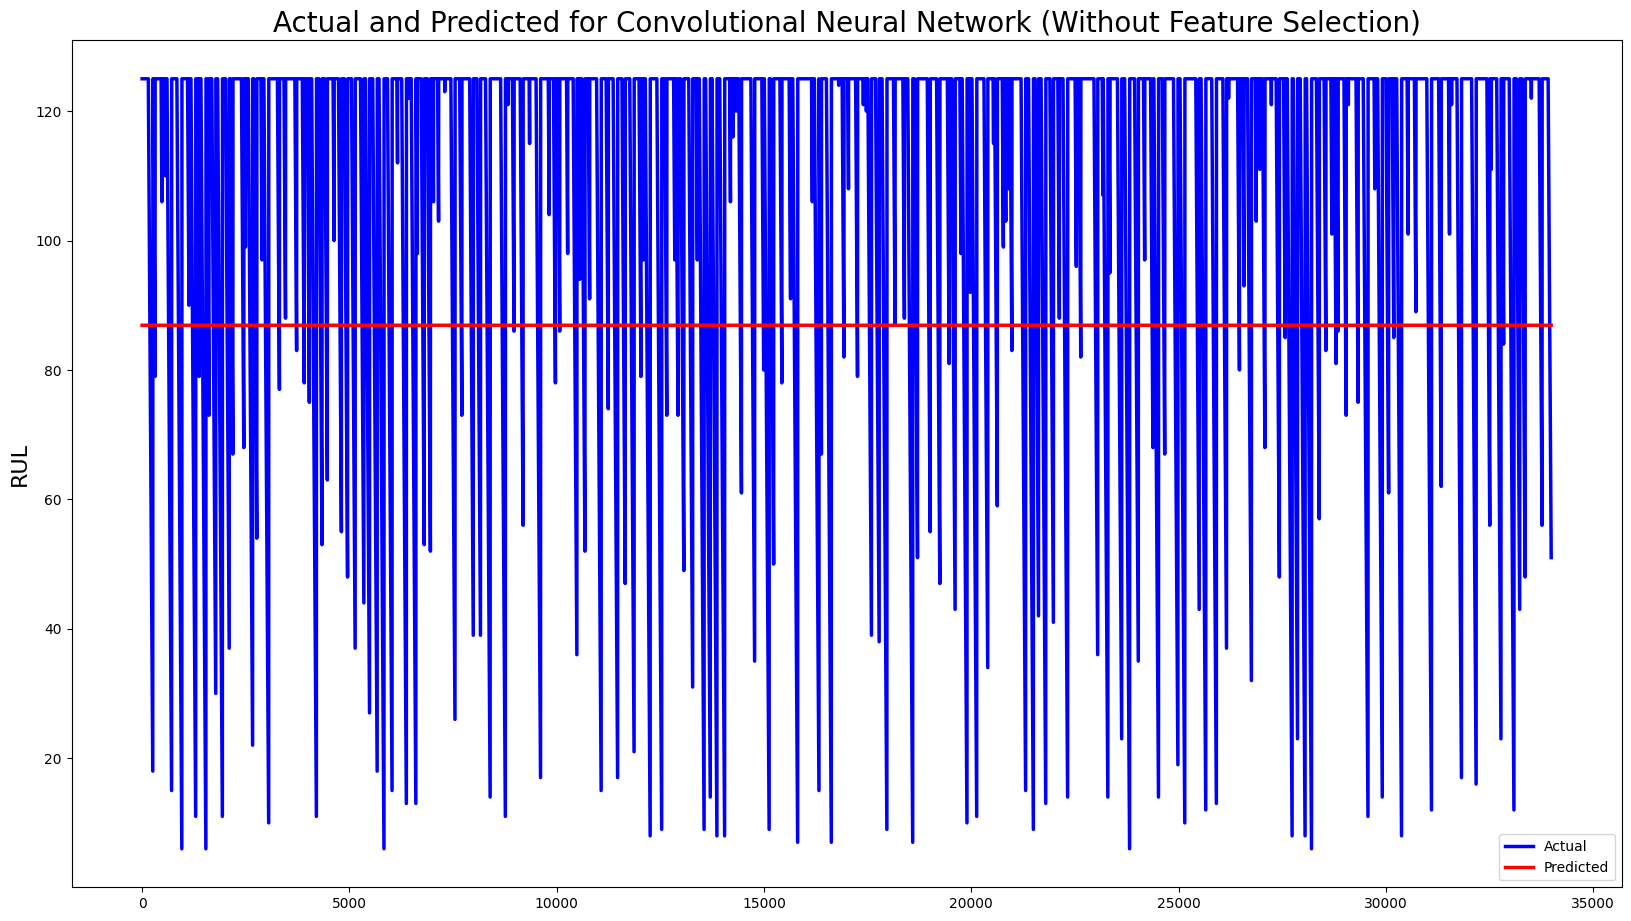

RMSE:  35.57211990049868
Loss:  1265.3785400390625
Industry score:  36.90499758860638


In [36]:
# Prediction 
y_pred_cnn = model.predict(X_test)

# Evaluation
mse_cnn = mean_squared_error(y_test,y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
loss = model.evaluate(X_test, y_test)
assym = assym_score(y_test, y_pred_cnn)

#Plotting
actual_vs_predicted('Convolutional Neural Network (Without Feature Selection)', y_test, y_pred_cnn)

#Results
print("RMSE: ", rmse_cnn)
print("Loss: ", loss)
print("Industry score: ", assym)

### Hyperparameter tuning for CNN

Parameters to tune:
* batch_size: 8, 16, 32, 64, 128
* epochs: 10, 30, 75
* optimizer: adam or sgd?

In [37]:
results_df = pd.DataFrame(columns=['Batch Size', 'Optimizer', 'Epochs', 'RMSE', 'Assymetric Loss'])
batch_sizes = [8, 16, 32, 64, 128]
epochs = [10, 30, 75]
optimizers = ['adam', 'sgd']

for batches in batch_sizes:
    for num_epochs in epochs:
        for opt in optimizers: 
            model = create_CNN()
            model.compile(optimizer=opt, loss='mean_squared_error')
            model.fit(X_train, y_train, batch_size = batches, epochs = num_epochs)
            y_pred_cnn = model.predict(X_test)
            mse_cnn = mean_squared_error(y_test,y_pred_cnn)
            rmse_cnn = mse_cnn ** 0.5
            assym = assym_score(y_test, y_pred_cnn)
            print(f"Batch size: {batches}, Optimizer: {opt}, Epochs: {num_epochs}")
            print("RMSE: ", rmse_cnn)
            print("Industry score: ", assym)
            results_df.loc[len(results_df.index)] = [batches, opt, num_epochs, rmse_cnn, assym]

Epoch 1/10
6720/6720 [==============================] - 4s 572us/step - loss: 7554.9150
Epoch 2/10
6720/6720 [==============================] - 4s 566us/step - loss: 5009.2856
Epoch 3/10
6720/6720 [==============================] - 4s 555us/step - loss: 3262.5627
Epoch 4/10
6720/6720 [==============================] - 4s 599us/step - loss: 2239.9534
Epoch 5/10
6720/6720 [==============================] - 4s 608us/step - loss: 1828.6279
Epoch 6/10
6720/6720 [==============================] - 4s 608us/step - loss: 1744.6327
Epoch 7/10
6720/6720 [==============================] - 4s 613us/step - loss: 1736.6354
Epoch 8/10
6720/6720 [==============================] - 4s 585us/step - loss: 1736.0344
Epoch 9/10
6720/6720 [==============================] - 4s 579us/step - loss: 1736.0308
Epoch 10/10
1063/1063 [==============================] - 1s 450us/step
Batch size: 8, Optimizer: adam, Epochs: 10
RMSE:  35.57127059507856
Industry score:  36.90157992890938
Epoch 1/10
6720/6720 [============

In [38]:
results_df

,Batch Size,Optimizer,Epochs,RMSE,Assymetric Loss
0,8,adam,10,35.571271,36.901580
1,8,sgd,10,35.437563,36.370749
2,8,adam,30,35.588465,36.970884
3,8,sgd,30,34.499298,33.042368
4,8,adam,75,35.601682,37.024313
5,8,sgd,75,37.044376,43.704993
6,16,adam,10,37.492294,46.132335
7,16,sgd,10,35.317204,35.905034
8,16,adam,30,35.524271,36.713339
9,16,sgd,30,37.064962,43.812781


The top performing hyperparameters were
* batch_size = 64
* optimizer = sgd
* epochs = 30

Epoch 1/75
6720/6720 [==============================] - 4s 540us/step - loss: 1756.1693
Epoch 2/75
6720/6720 [==============================] - 4s 526us/step - loss: 1742.2092
Epoch 3/75
6720/6720 [==============================] - 4s 526us/step - loss: 1743.0757
Epoch 4/75
6720/6720 [==============================] - 4s 543us/step - loss: 1741.8622
Epoch 5/75
6720/6720 [==============================] - 4s 541us/step - loss: 1743.0702
Epoch 6/75
6720/6720 [==============================] - 4s 540us/step - loss: 1742.8634
Epoch 7/75
6720/6720 [==============================] - 4s 543us/step - loss: 1742.3840
Epoch 8/75
6720/6720 [==============================] - 4s 536us/step - loss: 1742.5189
Epoch 9/75
6720/6720 [==============================] - 4s 536us/step - loss: 1742.7247
Epoch 10/75
6720/6720 [==============================] - 4s 534us/step - loss: 1742.8165
Epoch 11/75
6720/6720 [==============================] - 4s 538us/step - loss: 1742.3962
Epoch 12/75
6720/6720 [=======

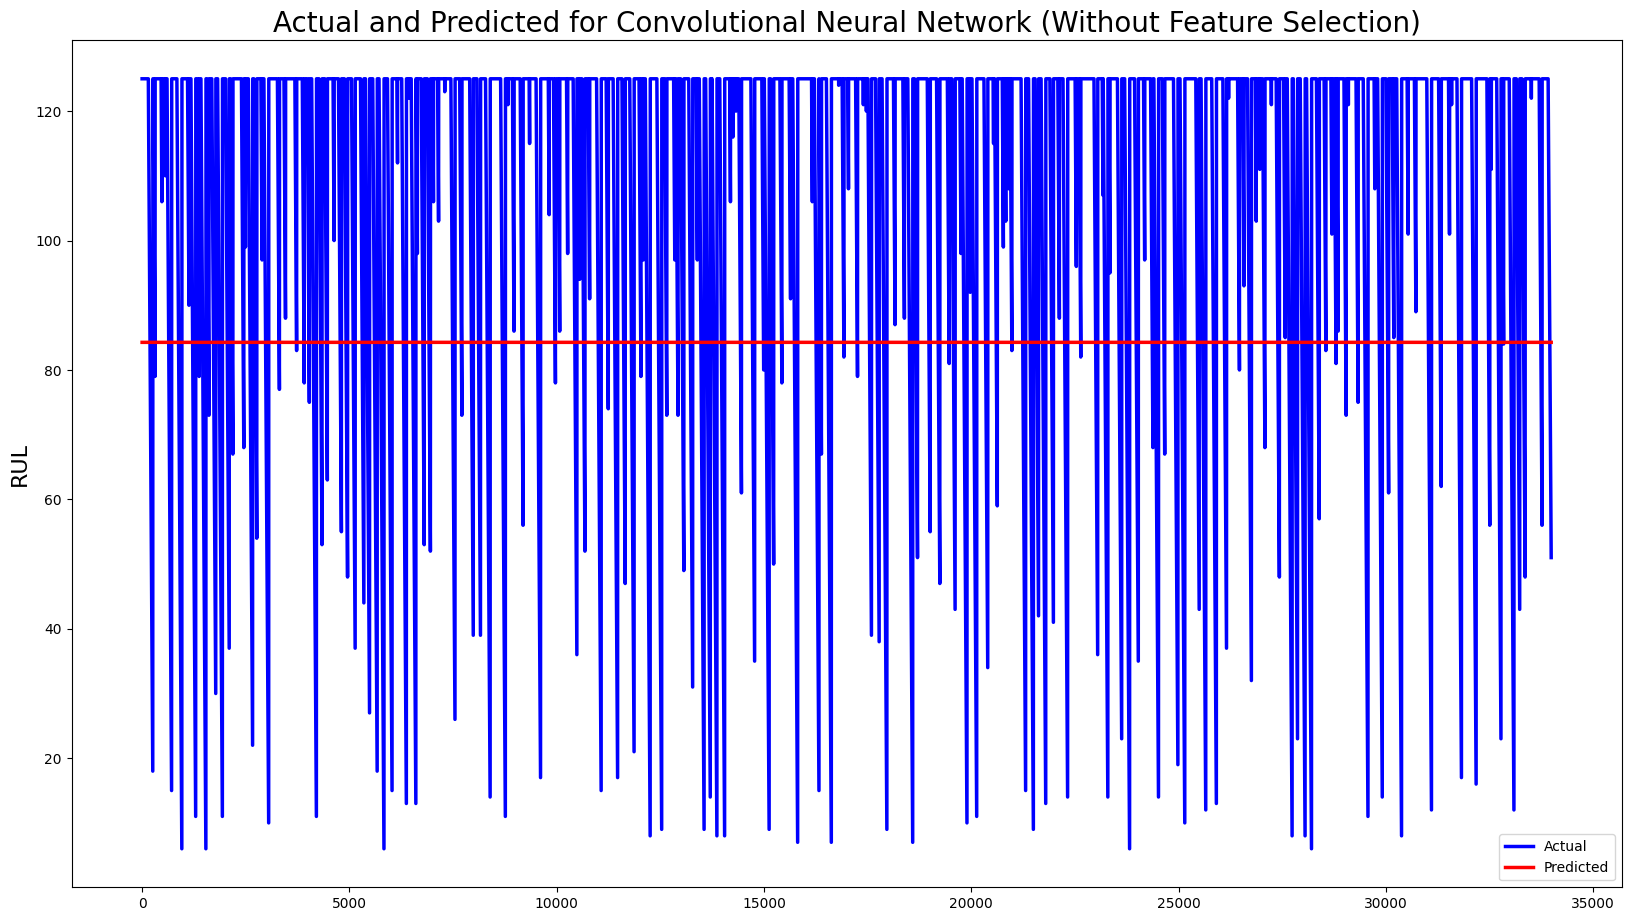

Batch size: 128, Optimizer: sgd, Epochs: 75
RMSE:  37.18095508663048
Industry score:  44.42684612484305


In [42]:
model = create_CNN()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 8, epochs = 75)
y_pred_cnn = model.predict(X_test)

actual_vs_predicted('Convolutional Neural Network (Without Feature Selection)', y_test, y_pred_cnn)

mse_cnn = mean_squared_error(y_test,y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
assym = assym_score(y_test, y_pred_cnn)
print(f"Batch size: {batches}, Optimizer: {opt}, Epochs: {num_epochs}")
print("RMSE: ", rmse_cnn)
print("Industry score: ", assym)

## Feature Selection

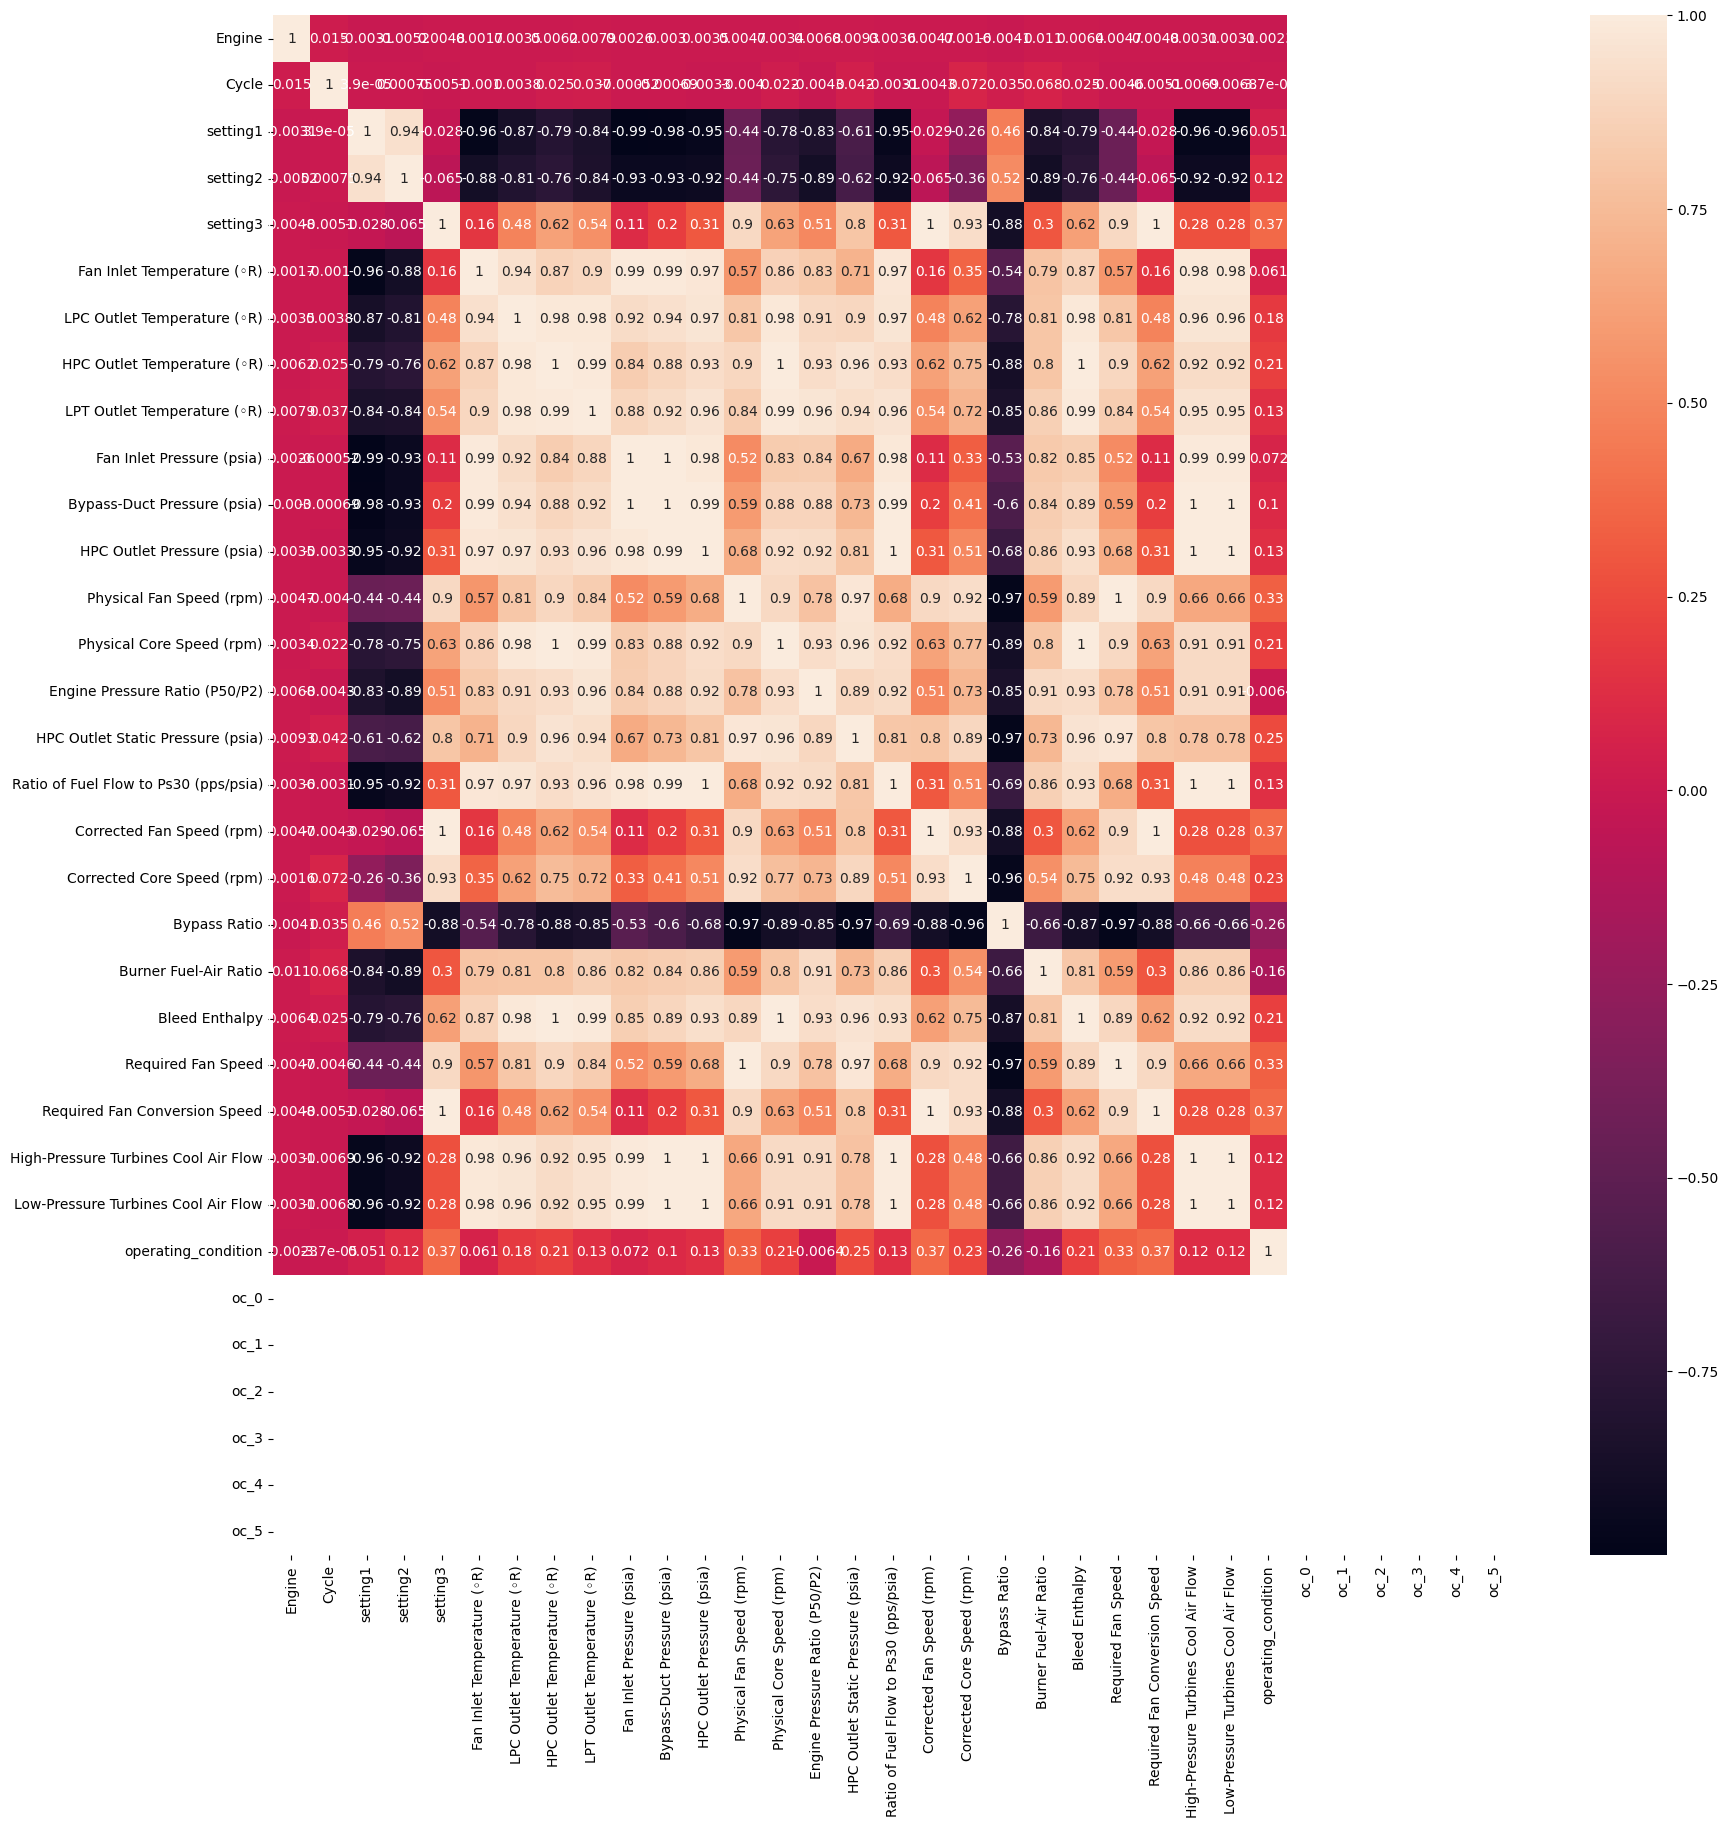

In [43]:
#Finding the correlated features using heatmap
plt.figure(figsize=(20,20))
sns.heatmap(train_data.drop('RUL',axis=1).corr(),cbar=True,annot=True,xticklabels=train_data.columns.drop('RUL'))
plt.savefig('Correlation Heatmap.png')
plt.show()

In [49]:
corr=train_data.corr()
train_relevant_features = corr[abs(corr['RUL'])>=0.01]

imp_features=train_relevant_features.index[1:]
print(f'These are the important features that we are going to consider: {imp_features}')

These are the important features that we are going to consider: Index(['HPC Outlet Temperature (◦R)', 'LPT Outlet Temperature (◦R)',
       'Physical Core Speed (rpm)', 'HPC Outlet Static Pressure (psia)',
       'Corrected Core Speed (rpm)', 'Bypass Ratio', 'Burner Fuel-Air Ratio',
       'Bleed Enthalpy', 'RUL'],
      dtype='object')


In [50]:
corr_train_data = train_data[imp_features]
corr_test_data = test_data[imp_features]

In [51]:
corr_train_data

,HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Physical Core Speed (rpm),HPC Outlet Static Pressure (psia),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,RUL
0,1358.61,1137.23,8341.91,42.02,8048.56,9.3461,0.02,334,125.0
1,1353.22,1125.78,8303.96,42.20,8072.30,9.3774,0.02,330,125.0
2,1256.76,1047.45,8001.42,36.69,7864.87,10.8941,0.02,309,125.0
3,1354.03,1126.38,8303.96,41.96,8068.66,9.3528,0.02,329,125.0
4,1257.71,1047.93,7993.23,36.89,7861.23,10.8963,0.02,309,125.0
...,...,...,...,...,...,...,...,...,...
53754,1495.60,1269.51,8852.27,44.72,8169.64,9.3035,0.03,369,4.0
53755,1514.32,1324.12,8915.86,46.08,8245.36,8.7586,0.03,374,3.0
53756,1276.24,1057.92,8114.33,37.14,7971.25,11.0657,0.02,310,2.0
53757,1272.95,1066.30,8112.63,37.32,7972.47,11.0537,0.02,311,1.0


In [52]:
corr_test_data

,HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Physical Core Speed (rpm),HPC Outlet Static Pressure (psia),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,RUL
0,1497.17,1304.99,8763.80,45.61,8114.10,8.6476,0.03,369,125.0
1,1481.20,1246.11,8713.21,44.26,8053.06,9.2405,0.02,364,125.0
2,1359.08,1128.36,8340.20,41.80,8053.04,9.3472,0.02,333,125.0
3,1349.69,1127.89,8313.85,42.21,8066.90,9.3961,0.02,332,125.0
4,1253.18,1050.69,7997.13,36.76,7865.66,10.8682,0.02,305,125.0
...,...,...,...,...,...,...,...,...,...
33986,1366.01,1129.47,8367.35,41.96,8088.36,9.3215,0.02,334,55.0
33987,1351.13,1123.86,8339.94,42.00,8108.48,9.3542,0.02,332,54.0
33988,1349.14,1118.91,8341.70,42.15,8098.77,9.3836,0.02,331,53.0
33989,1589.61,1408.16,9077.35,47.47,8161.85,8.4279,0.03,393,52.0


In [53]:
# seperate training and testing data
X_train=corr_train_data.drop('RUL',axis=1)
y_train=corr_train_data[['RUL']]

In [54]:
X_train.head()

,HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Physical Core Speed (rpm),HPC Outlet Static Pressure (psia),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy
0,1358.61,1137.23,8341.91,42.02,8048.56,9.3461,0.02,334
1,1353.22,1125.78,8303.96,42.20,8072.30,9.3774,0.02,330
2,1256.76,1047.45,8001.42,36.69,7864.87,10.8941,0.02,309
3,1354.03,1126.38,8303.96,41.96,8068.66,9.3528,0.02,329
4,1257.71,1047.93,7993.23,36.89,7861.23,10.8963,0.02,309


In [55]:
y_train

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
53754,4.0
53755,3.0
53756,2.0
53757,1.0


In [56]:
X_test=corr_test_data.drop('RUL',axis=1)
y_test=corr_test_data[['RUL']]

In [57]:
X_test

,HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Physical Core Speed (rpm),HPC Outlet Static Pressure (psia),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy
0,1497.17,1304.99,8763.80,45.61,8114.10,8.6476,0.03,369
1,1481.20,1246.11,8713.21,44.26,8053.06,9.2405,0.02,364
2,1359.08,1128.36,8340.20,41.80,8053.04,9.3472,0.02,333
3,1349.69,1127.89,8313.85,42.21,8066.90,9.3961,0.02,332
4,1253.18,1050.69,7997.13,36.76,7865.66,10.8682,0.02,305
...,...,...,...,...,...,...,...,...
33986,1366.01,1129.47,8367.35,41.96,8088.36,9.3215,0.02,334
33987,1351.13,1123.86,8339.94,42.00,8108.48,9.3542,0.02,332
33988,1349.14,1118.91,8341.70,42.15,8098.77,9.3836,0.02,331
33989,1589.61,1408.16,9077.35,47.47,8161.85,8.4279,0.03,393


In [58]:
y_test

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
33986,55.0
33987,54.0
33988,53.0
33989,52.0


In [59]:
print(f'The shape of the training data : {X_train.shape} , {y_train.shape}')
print(f'The shape of the testing data : {X_test.shape} , {y_test.shape}')

The shape of the training data : (53759, 8) , (53759, 1)
The shape of the testing data : (33991, 8) , (33991, 1)


#### Normalization

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Gradient Boosting over Feature Selected Dataset

In [61]:
#Fitting
grad = GradientBoostingRegressor()
grad.fit(X_train,y_train)

GradientBoostingRegressor()

In [62]:
# Parameter grid
param_grid_GBT = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [int(x) for x in np.linspace(10,100,10)],
    'max_depth': [int(x) for x in np.linspace(5,30,6)],
    'min_samples_split': [2,5,10,15,100],
    'min_samples_leaf': [1,2,5,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'subsample': [0.6, 0.8, 1.0]
}

In [63]:
# Fitting
hyperparameter_tuned_GBT = RandomizedSearchCV(estimator=grad,param_distributions=param_grid_GBT)

In [64]:
hyperparameter_tuned_GBT.fit(X_train,y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100],
                                        'subsample': [0.6, 0.8, 1.0]})

In [65]:
print('The parameters which are considered to be the best for the model are : ')
hyperparameter_tuned_GBT.best_params_

The parameters which are considered to be the best for the model are : 


{'subsample': 0.8,
 'n_estimators': 50,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15,
 'learning_rate': 0.1}

In [66]:
# Prediction
y_pred_grad_tuned = hyperparameter_tuned_GBT.predict(X_test)

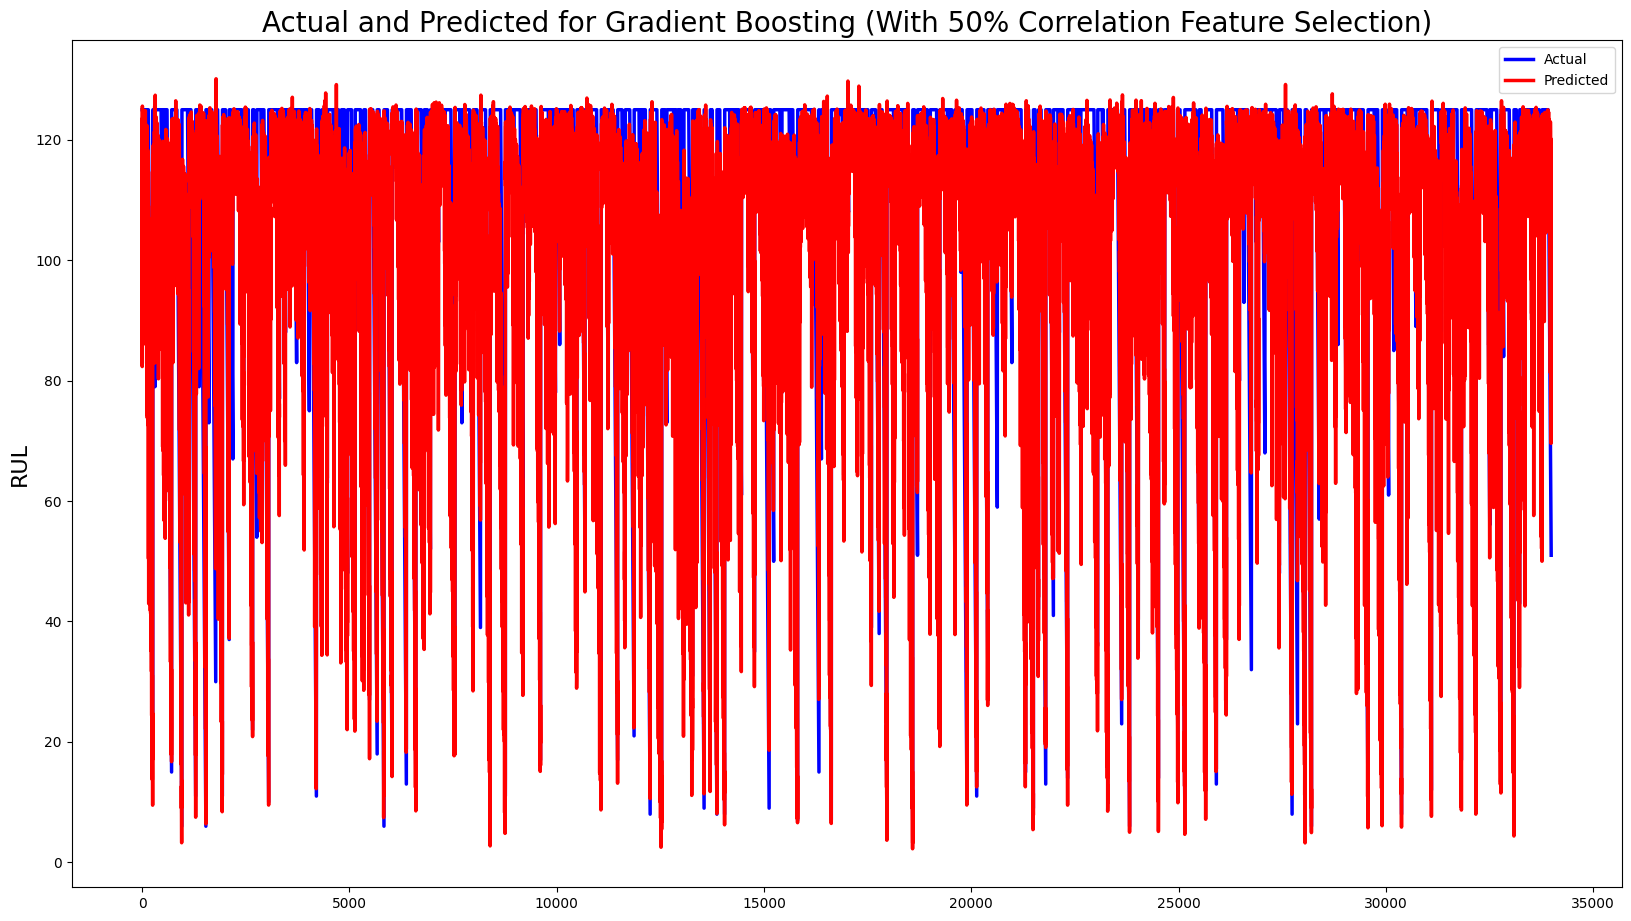

RMSE:  19.809767480965462
Industry score:  36207751.861632936


In [68]:
#Evaluation
mse_grad = mean_squared_error(y_test,y_pred_grad_tuned)
rmse_grad = mse_grad ** 0.5
assym = assym_score(y_test, y_pred_grad_tuned)

#Plotting
actual_vs_predicted('Gradient Boosting (With 50% Correlation Feature Selection)', y_test, y_pred_grad_tuned)

#Results
print("RMSE: ", rmse_grad)
print("Industry score: ", assym)

### CNN over feature-selected dataset

In [71]:
def create_CNN():
    model = Sequential()
    # Input layer
    model.add(Conv1D(14, 4, activation='sigmoid', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(2, strides=2))
    
    # Hidden layers
    model.add(Conv1D(8, 2, activation='sigmoid', padding='same'))
    #model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(8, 12, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(6, 6, activation='sigmoid', padding='same'))
    #model.add(MaxPooling1D(2, strides=2))
    
    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    
    # Output layer
    model.add(Dense(1))
    return model

In [72]:
results_df = pd.DataFrame(columns=['Batch Size', 'Optimizer', 'Epochs', 'RMSE', 'Assymetric Loss'])
batch_sizes = [8, 16, 32, 64, 128]
epochs = [10, 30, 75]
optimizers = ['adam', 'sgd']

for batches in batch_sizes:
    for num_epochs in epochs:
        for opt in optimizers: 
            model = create_CNN()
            model.compile(optimizer=opt, loss='mean_squared_error')
            model.fit(X_train, y_train, batch_size = batches, epochs = num_epochs)
            y_pred_cnn = model.predict(X_test)
            mse_cnn = mean_squared_error(y_test, y_pred_cnn)
            rmse_cnn = mse_cnn ** 0.5
            assym = assym_score(y_test, y_pred_cnn)
            print(f"Batch size: {batches}, Optimizer: {opt}, Epochs: {num_epochs}")
            print("RMSE: ", rmse_cnn)
            print("Industry score: ", assym)
            #df.loc[len(df)] = [4, 'd']
            results_df.loc[len(results_df.index)] = [batches, opt, num_epochs, rmse_cnn, assym]

Epoch 1/10
6720/6720 [==============================] - 4s 509us/step - loss: 8107.7974
Epoch 2/10
6720/6720 [==============================] - 3s 487us/step - loss: 5503.1108
Epoch 3/10
6720/6720 [==============================] - 3s 484us/step - loss: 3585.4578
Epoch 4/10
6720/6720 [==============================] - 3s 493us/step - loss: 2405.7449
Epoch 5/10
6720/6720 [==============================] - 3s 496us/step - loss: 1879.2542
Epoch 6/10
6720/6720 [==============================] - 3s 491us/step - loss: 1750.8212
Epoch 7/10
6720/6720 [==============================] - 3s 496us/step - loss: 1737.0725
Epoch 8/10
6720/6720 [==============================] - 3s 491us/step - loss: 1736.1171
Epoch 9/10
6720/6720 [==============================] - 3s 492us/step - loss: 1736.0159
Epoch 10/10
1063/1063 [==============================] - 0s 314us/step
Batch size: 8, Optimizer: adam, Epochs: 10
RMSE:  35.55081853986109
Industry score:  36.819451908362645
Epoch 1/10
6720/6720 [===========

In [73]:
results_df

,Batch Size,Optimizer,Epochs,RMSE,Assymetric Loss
0,8,adam,10,35.550819,36.819452
1,8,sgd,10,35.355614,36.052274
2,8,adam,30,35.554150,36.832806
3,8,sgd,30,33.269054,29.741679
4,8,adam,75,35.642864,37.191681
5,8,sgd,75,35.964379,38.544724
6,16,adam,10,37.612992,46.816245
7,16,sgd,10,35.623914,37.114497
8,16,adam,30,35.577538,36.926816
9,16,sgd,30,35.306744,35.865101


Epoch 1/30
6720/6720 [==============================] - 3s 466us/step - loss: 1752.7977
Epoch 2/30
6720/6720 [==============================] - 3s 454us/step - loss: 1743.0552
Epoch 3/30
6720/6720 [==============================] - 3s 463us/step - loss: 1742.3716
Epoch 4/30
6720/6720 [==============================] - 3s 451us/step - loss: 1743.2990
Epoch 5/30
6720/6720 [==============================] - 3s 443us/step - loss: 1743.0905
Epoch 6/30
6720/6720 [==============================] - 3s 428us/step - loss: 1742.4720
Epoch 7/30
6720/6720 [==============================] - 3s 438us/step - loss: 1742.9235
Epoch 8/30
6720/6720 [==============================] - 3s 476us/step - loss: 1741.6831
Epoch 9/30
6720/6720 [==============================] - 3s 435us/step - loss: 1743.0454
Epoch 10/30
6720/6720 [==============================] - 3s 478us/step - loss: 1743.0603
Epoch 11/30
6720/6720 [==============================] - 3s 487us/step - loss: 1742.0865
Epoch 12/30
6720/6720 [=======

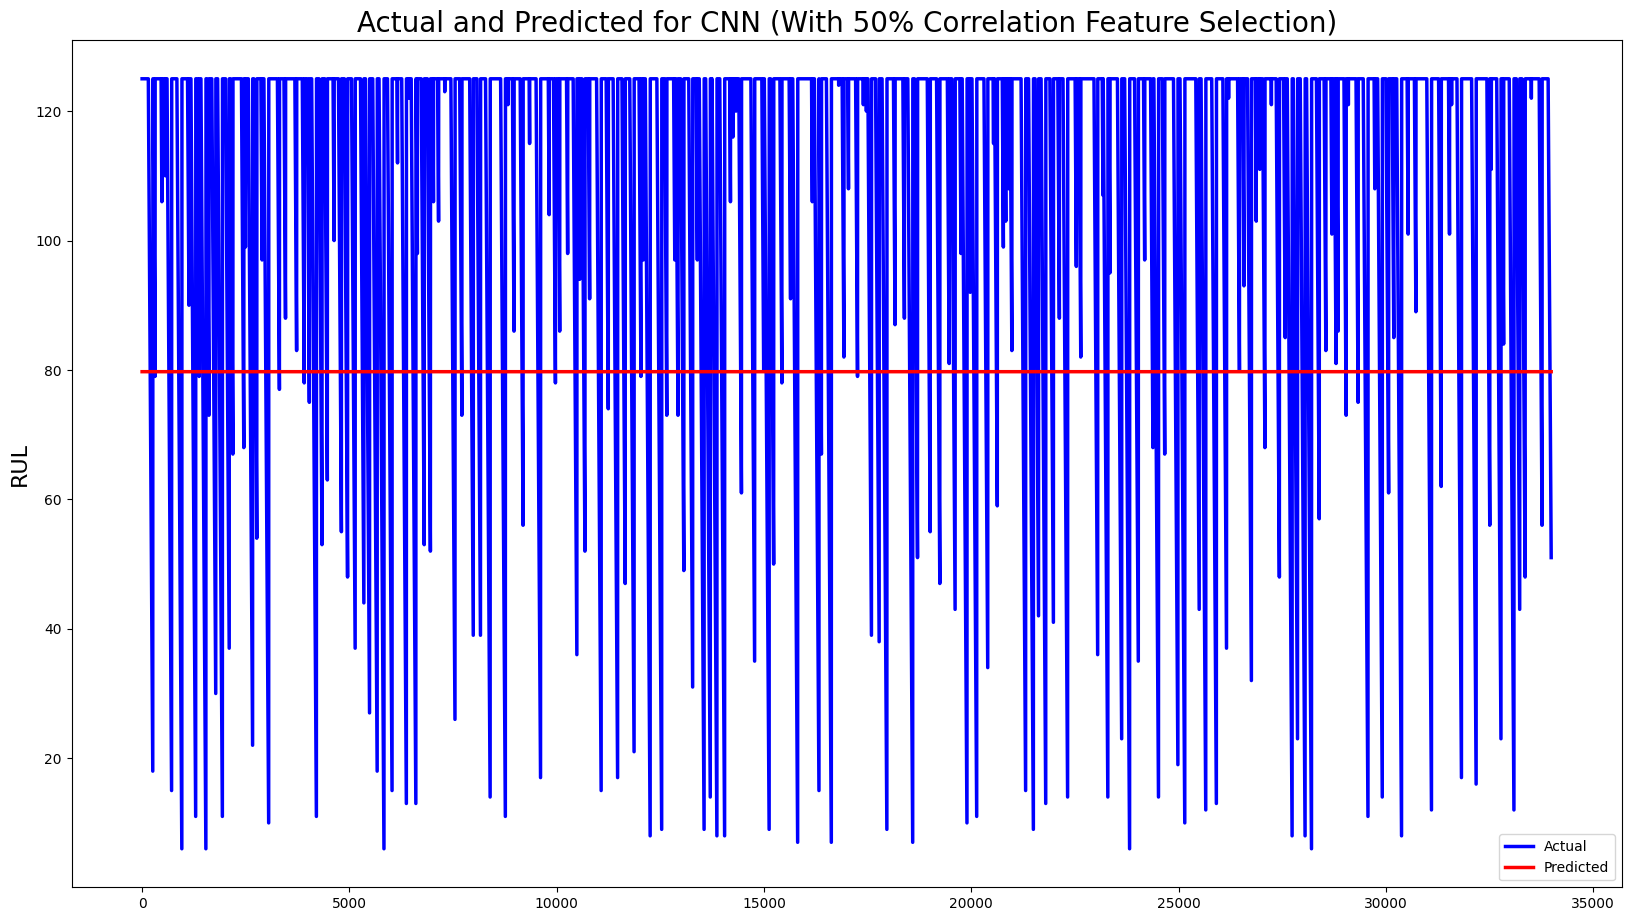

RMSE:  40.19966954660861
Industry score:  64.77360529655681


In [76]:
model = create_CNN()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 8, epochs = 30)
y_pred_cnn = model.predict(X_test)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
assym = assym_score(y_test, y_pred_cnn)
actual_vs_predicted('CNN (With 50% Correlation Feature Selection)', y_test, y_pred_cnn)
print("RMSE: ", rmse_cnn)
print("Industry score: ", assym)

Epoch 1/100
323/323 [==============================] - 1s 822us/step - loss: 1976.1561
Epoch 2/100
323/323 [==============================] - 0s 777us/step - loss: 1737.2794
Epoch 3/100
323/323 [==============================] - 0s 759us/step - loss: 1736.9686
Epoch 4/100
323/323 [==============================] - 0s 770us/step - loss: 1738.0573
Epoch 5/100
323/323 [==============================] - 0s 745us/step - loss: 1737.6069
Epoch 6/100
323/323 [==============================] - 0s 743us/step - loss: 1737.4469
Epoch 7/100
323/323 [==============================] - 0s 745us/step - loss: 1737.4642
Epoch 8/100
323/323 [==============================] - 0s 744us/step - loss: 1737.8917
Epoch 9/100
323/323 [==============================] - 0s 779us/step - loss: 1737.2092
Epoch 10/100
323/323 [==============================] - 0s 746us/step - loss: 1737.6110
Epoch 11/100
323/323 [==============================] - 0s 744us/step - loss: 1737.8179
Epoch 12/100
323/323 [===================

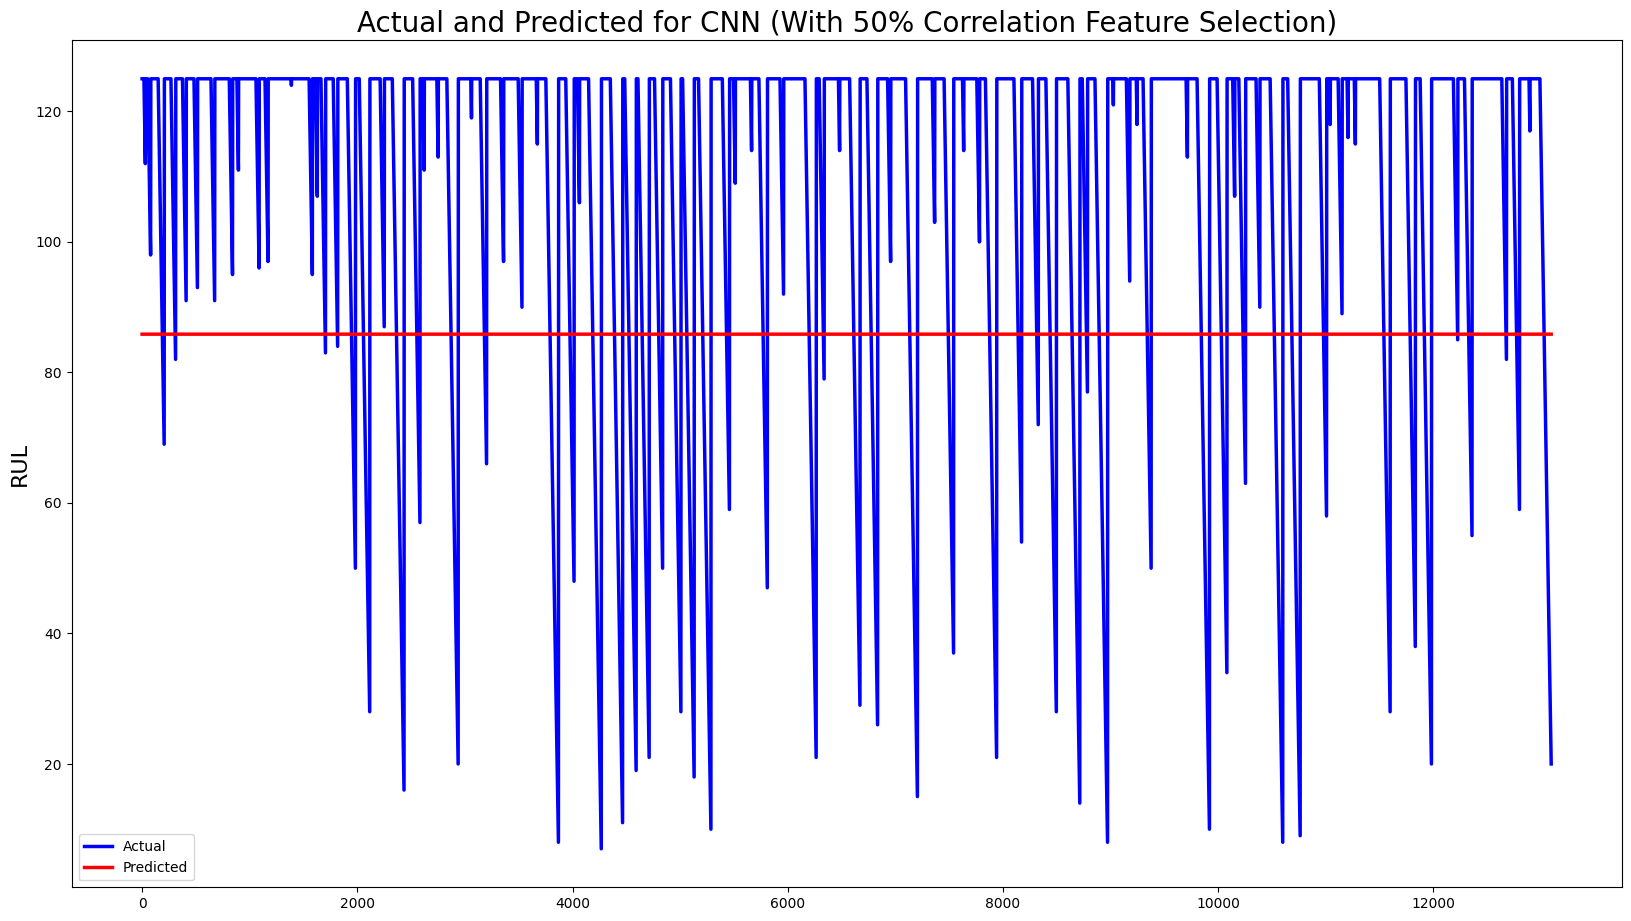

RMSE:  35.94802185920641
Industry score:  38.56919276120992


In [132]:
model = create_CNN()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 64, epochs = 75)
y_pred_cnn = model.predict(X_test)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
assym = assym_score(y_test, y_pred_cnn)
actual_vs_predicted('CNN (With 50% Correlation Feature Selection)', y_test, y_pred_cnn)
print("RMSE: ", rmse_cnn)
print("Industry score: ", assym)

In [110]:
X_train=train_data.drop('RUL', axis=1)
y_train=train_data[['RUL']]

In [52]:
X_test=test_data[X_train.columns]
X_test.head()

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),...,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,100.0,38.86,23.3735,5,0,0,0,0,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,100.0,39.02,23.3916,4,0,0,0,0,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,100.0,39.08,23.4166,2,0,0,0,0,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,100.0,39.00,23.3737,1,0,0,0,0,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,100.0,38.99,23.4130,2,0,0,0,0,0,0


In [53]:
y_test

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [56]:
#The same time cycle that each engine revolves for the testing data
time_cycle_each_test = []
for i in range(1,101):
    time_cycle_each_test.append(len(test_data.Cycle[test_data['Engine']==i]))

In [57]:
y_test = pd.DataFrame({'RUL': np.repeat(y_test['RUL'], time_cycle_each_test)})
y_test.set_index(i for i in range(13096))

,RUL
0,112
1,112
2,112
3,112
4,112
...,...
13091,20
13092,20
13093,20
13094,20


In [58]:
print(f'The shape of the training data : {X_train.shape} , {y_train.shape}')
print(f'The shape of the testing data : {X_test.shape} , {y_test.shape}')

The shape of the training data : (20631, 33) , (20631, 1)
The shape of the testing data : (13096, 33) , (13096, 1)


In [1]:
# Normalization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'X_train' is not defined

In [60]:
def actual_vs_predicted(model, y_test, y_pred):
    plt.figure(figsize=(20,11))
    plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
    plt.plot(y_pred,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
    plt.title(f'Actual and Predicted for {model}', fontsize=20)                                        
    plt.ylabel('RUL', fontsize=16)                           
    plt.legend()
    plt.savefig(f'Actual VS Predicted {model}.png')
    plt.show()

/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


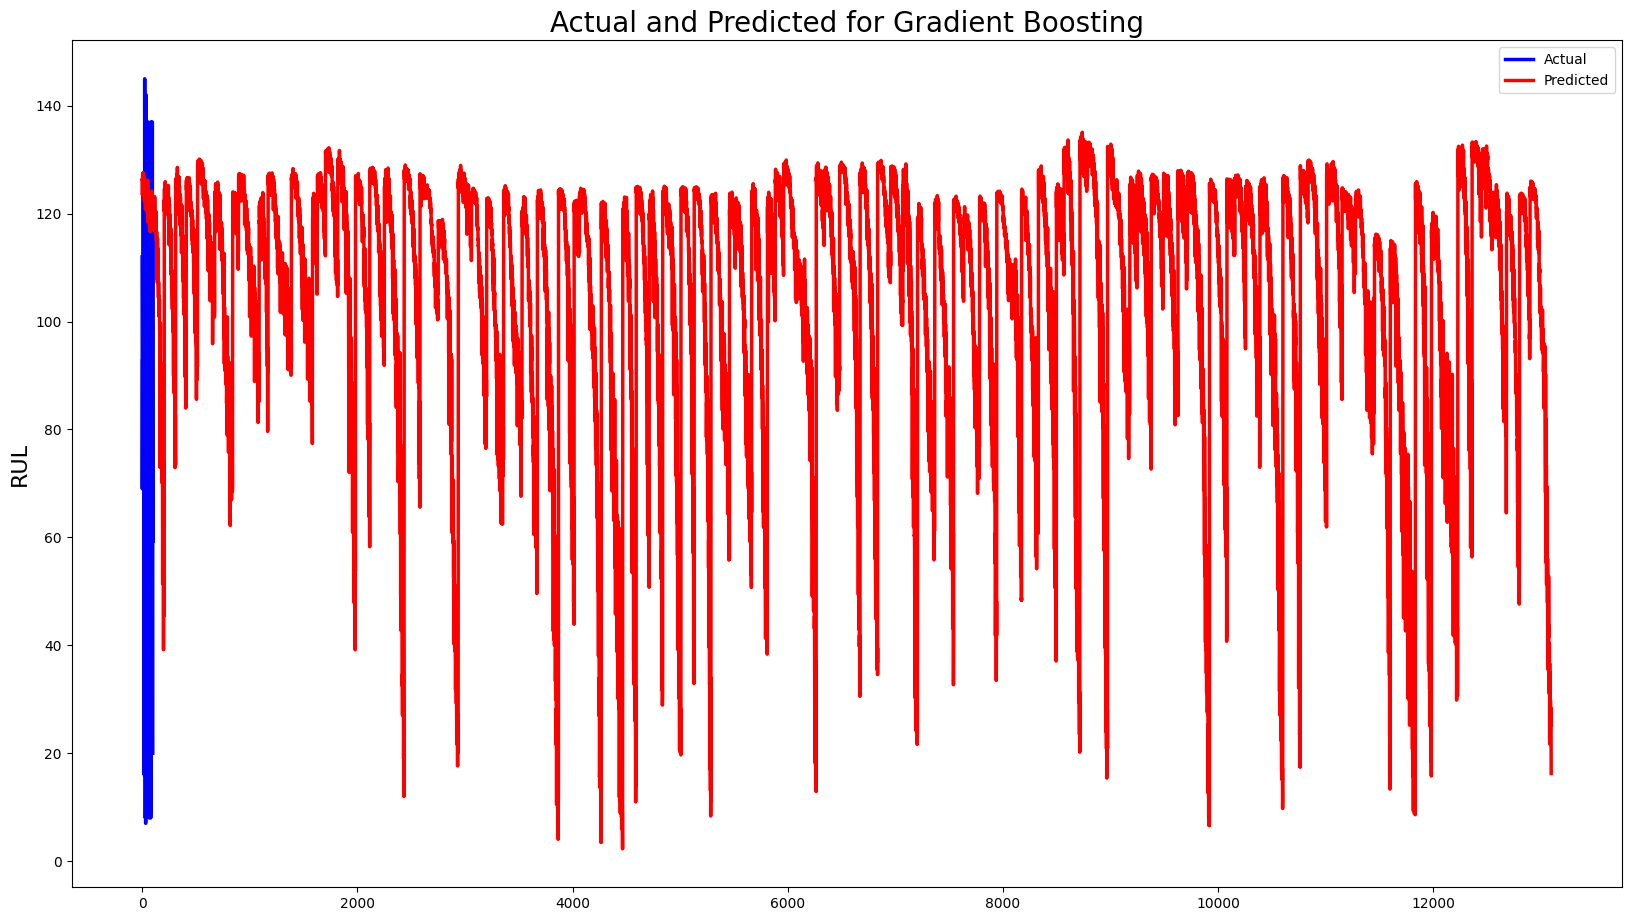

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

#Fitting
grad = GradientBoostingRegressor()
grad.fit(X_train,y_train)

#Prediction
y_pred_grad = grad.predict(X_test)

#Evalutation
mse_grad = mean_squared_error(y_test, y_pred_grad)
rmse_grad = mse_grad ** 0.5
r2_grad = abs(r2_score(y_test, y_pred_grad))
acc_grad = round(grad.score(X_train,y_train),2)*100

#Plotting
actual_vs_predicted('Gradient Boosting', y_test, y_pred_grad)

#Results
Results = pd.DataFrame(({'Model':['Gradient Boosting'],'MSE':[mse_grad],'RMSE':[rmse_grad],'R2':[r2_grad],'Accuracy':[acc_grad]}))


In [65]:
Results

,Model,MSE,RMSE,R2,Accuracy
0,Gradient Boosting,3296.545911,57.415555,0.92448,90.0


Epoch 1/150
645/645 [==============================] - 1s 878us/step - loss: 9003.9121
Epoch 2/150
645/645 [==============================] - 1s 830us/step - loss: 8615.1787
Epoch 3/150
645/645 [==============================] - 1s 821us/step - loss: 8270.5098
Epoch 4/150
645/645 [==============================] - 1s 821us/step - loss: 7957.7134
Epoch 5/150
645/645 [==============================] - 1s 811us/step - loss: 7660.0962
Epoch 6/150
645/645 [==============================] - 1s 809us/step - loss: 7373.4863
Epoch 7/150
645/645 [==============================] - 1s 810us/step - loss: 7096.1968
Epoch 8/150
645/645 [==============================] - 1s 810us/step - loss: 6826.9746
Epoch 9/150
645/645 [==============================] - 1s 807us/step - loss: 6565.6499
Epoch 10/150
645/645 [==============================] - 1s 809us/step - loss: 6311.9502
Epoch 11/150
645/645 [==============================] - 1s 806us/step - loss: 6065.6885
Epoch 12/150
645/645 [===================

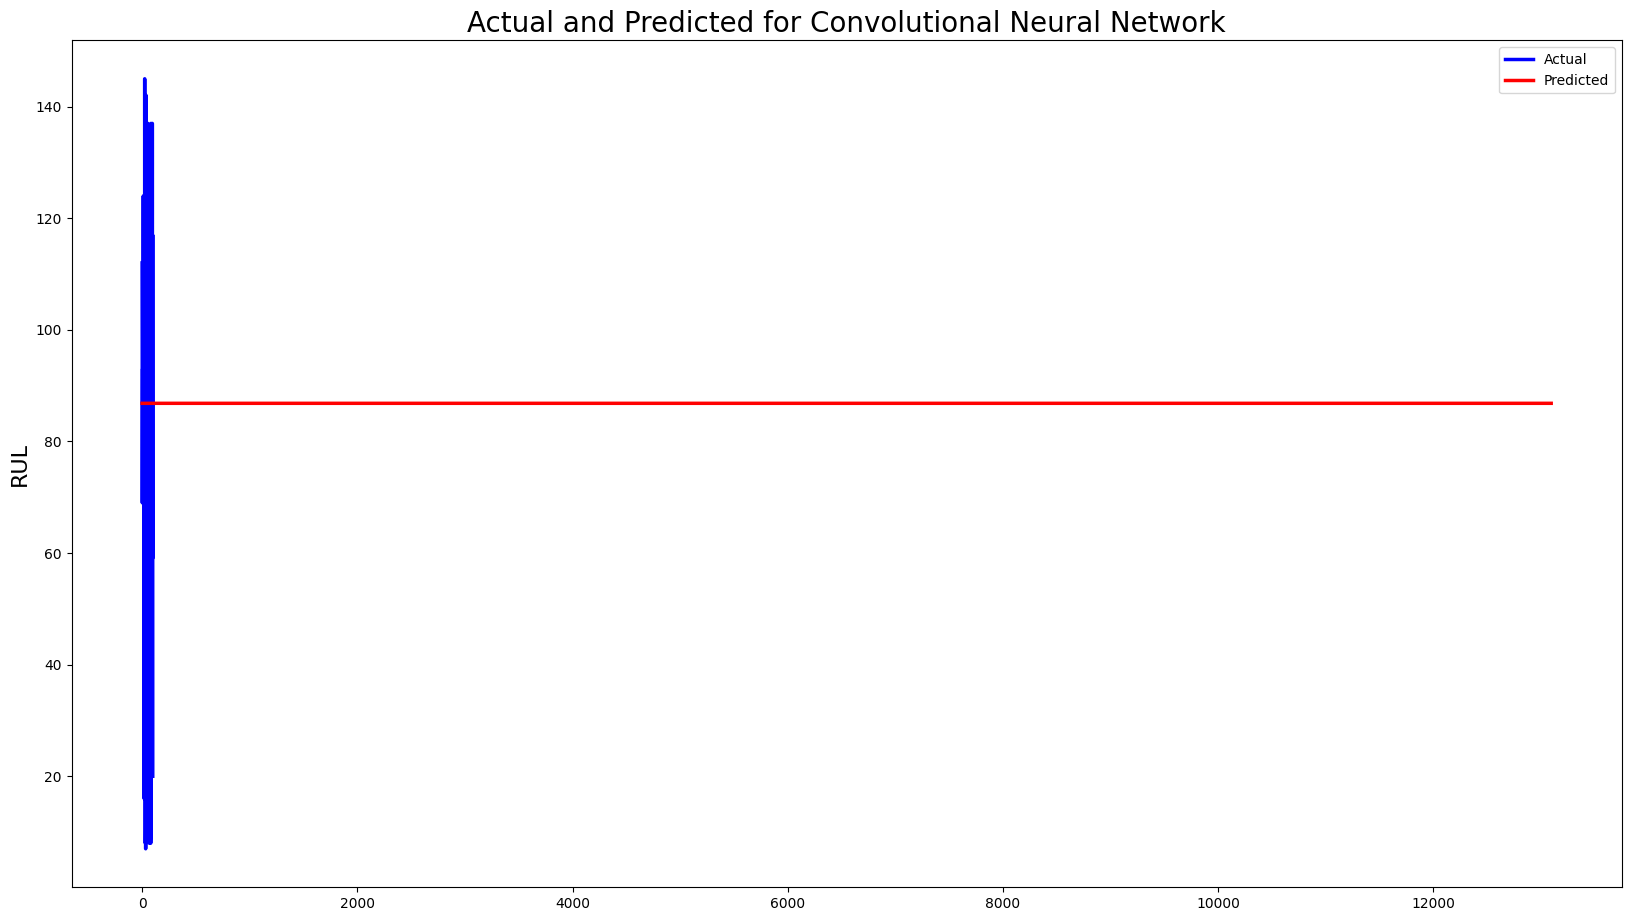

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()

# Input layer
model.add(Conv1D(14, 4, activation='sigmoid', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2, strides=2))

# Hidden layers
model.add(Conv1D(8, 2, activation='sigmoid', padding='same'))
model.add(MaxPooling1D(2, strides=2))
model.add(Conv1D(8, 12, activation='sigmoid', padding='same'))
model.add(MaxPooling1D(2, strides=2))
model.add(Conv1D(6, 6, activation='sigmoid', padding='same'))
model.add(MaxPooling1D(2, strides=2))

# Fully connected layer
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

# Output layer
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# # Convert DataFrames to NumPy arrays
# train_data = train_data.to_numpy()
# test_data = test_data.to_numpy()

# # Reshape your data to fit the model
# train_data = train_data.reshape((20631, 33, 1))
# test_data = test_data.reshape((13096, 33, 1))

# Train the model
model.fit(X_train, y_train, batch_size = 32, epochs = 150)

# Prediction 
y_pred_cnn = model.predict(X_test)

# Evaluation
mse_cnn = mean_squared_error(y_test,y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
r2_cnn = abs(r2_score(y_test, y_pred_cnn))
loss = model.evaluate(X_test, y_test)

#Plotting
actual_vs_predicted('Convolutional Neural Network', y_test, y_pred_cnn)
plot_model(model, to_file='cnn.png', show_shapes=True, show_layer_names=True)

#Results
Results.loc[len(Results.index)]=['CNN', mse_cnn, rmse_cnn, r2_cnn, accuracy]

In [99]:
Results

,Model,MSE,RMSE,R2,Accuracy
0,Gradient Boosting,3296.545911,57.415555,0.924480,90.000000
1,ANN,3391.279385,58.234692,0.979784,46.447018
2,CNN,3391.279385,58.234692,0.979784,46.137836
3,CNN,2171.884083,46.603477,0.267917,46.137836


In [103]:
train_data

array([[ 1.00e+00,  1.00e+00, -7.00e-04, ...,  0.00e+00,  0.00e+00,
         1.25e+02],
       [ 1.00e+00,  2.00e+00,  1.90e-03, ...,  0.00e+00,  0.00e+00,
         1.25e+02],
       [ 1.00e+00,  3.00e+00, -4.30e-03, ...,  0.00e+00,  0.00e+00,
         1.25e+02],
       ...,
       [ 1.00e+02,  1.98e+02,  4.00e-04, ...,  0.00e+00,  0.00e+00,
         2.00e+00],
       [ 1.00e+02,  1.99e+02, -1.10e-03, ...,  0.00e+00,  0.00e+00,
         1.00e+00],
       [ 1.00e+02,  2.00e+02, -3.20e-03, ...,  0.00e+00,  0.00e+00,
         0.00e+00]])

In [102]:
# Feature selection
plt.figure(figsize=(20,20))
sns.heatmap(train_data.drop('RUL',axis=1).corr(),cbar=True,annot=True,xticklabels=train_data.columns)
plt.savefig('Correlation Heatmap.png')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

<Figure size 2000x2000 with 0 Axes>